In [1]:
import sqlite3
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score


import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect("shop_database.db") 
cursor = conn.cursor()

# Проверим, какие таблицы есть в базе
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('purchases',), ('personal_data_coeffs',), ('personal_data',)]


In [3]:
# Загружаем таблицы
purchases = pd.read_sql('SELECT * FROM purchases;', conn)
personal_data_coeffs = pd.read_sql('SELECT * FROM personal_data_coeffs;', conn)
personal_data = pd.read_sql('SELECT * FROM personal_data;', conn)
dop_data = pd.read_csv('personal_data.csv')

In [4]:
# таблица purchases

In [5]:
# Почистим product
purchases['product'] = (
    purchases['product']
    .str.lower()
    .str.replace('ё', 'е', regex=False)
    .str.replace(r'[^a-zа-я0-9\s"]', '')
    .str.replace(r'\s+', ' ')
    .str.strip()
)

C:\Users\ST\AppData\Local\Temp\ipykernel_9576\2488809461.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  purchases['product']


In [6]:
purchases['name_product'] = purchases['product'].str.split().str[0]

In [7]:
def categorize_product(x):
    
    x = str(x).split()
    word = x[0]
    
    if word in ['комплект', 'комлект', 'комплекты', 'набор', 'детский', 'детские', 'детская', 'женский', 'женская', 'мужской', 'мужские', 'детское']:
        word = x[1]
        
    if word in ['кроссовки', 'ботинки', 'туфли', 'сандалии', 'шлепанцы', 'сапоги', 'сабо', 'велотуфли', 'sneakers', 'велообувь', 'шиповки', 'джазовки', 'northland', 'горнолыжные', 'мокасины', 'обувь', 'joss', 'тапочки', 'футзальная', 'giy', 'полуботинки', 'low', 'слипоны', 'сноубордические', 'боксерки', 'велоботинки', 'стельки', 'сороконожки', 'кеды', 'бутсы', 'балетки', 'эспадрильи', 'полупальто', 'полусапоги']:
        return 'обувь'
    elif word in ['брюки', 'шорты', 'легинсы', 'боди', 'джинсы', 'водолазка', 'тайсы', 'рейтузы', 'arcteryx', 'шортысамосбросы', 'qun', 'оверсайз', 'кальсоны', 'купальные', 'termit', 'fila', 'непромокаемые', 'nike', 'trousers', 'socks', 'бордшорты', 'брюкишорты', 'компрессионные', 'волейбольной', 'удлиненная', 'бесшовный', 'футболка', 'худи', 'велобриджи', 'толстовка', 'купальный', 'спортивное', 'парадный', 'халатпончо', 'юниорские', 'спортивные', 'детский', 'веткровка', 'sports', 'рукав', 'гостевая', 'домашняя', 'tshirt', 'mens', 'puma', 'womens', 'непромокаемая', 'шортысауна', 'джаммеры', 'водоотталкивающий', 'ветровка', 'флисовый', 'одежды', 'футболки', 'пончо', 'свитер', 'добок', 'мембранной', 'накидкадождевик', 'юниорский', 'парка', 'тайтсы', 'стартовый', 'манишка', 'футбольной', 'свитшот', 'полукомбинезон', 'моделирующие', 'баскетбольной', 'курткаанорак', 'лосины', 'топ', 'леггинсы', 'дождевик', 'джерси', 'кимоно', 'гамаши', 'комбинезон', 'бра', 'брюкисамосбросы', 'велошорты', 'лонгслив', 'термобелья', 'джемпер', 'бикини', 'майка', 'рубашка', 'анорак', 'поло', 'трико', 'платье', 'костюм', 'бриджи', 'гольфы', 'туника', 'рубашкаполо', 'юбкашорты', 'олимпийка', 'бомбер', 'велосипедки', 'юбка', 'рашгард', 'куртка', 'пуховик', 'ветровка', 'жилет', 'пальто', 'трусы', 'лиф', 'носки', 'купальник', 'плавки', 'плавкишорты', 'термобелье', 'гетры', 'легкая', 'волейбольной']:
        return 'одежда'
    elif word in ['подарочная', 'пакет', 'упаковка', 'сумка', 'рюкзак', 'сумкашопер', 'помада', 'рюкзакупаковка', 'губкаочиститель', 'футляр', 'сумки', 'сушилки', 'защитных', 'чистящая', 'растворитель', 'ремешок', 'зимний', 'вкладыши', 'аквагримм', 'смягчающее', 'охлаждающий', 'наклейка', 'сумкачехол', 'сквиш', 'шапкашлем', 'лосьон', 'пятновыводящие', 'затягиватель', 'наушники', 'коробочка', 'губка', 'беспроводные', 'шарф', 'снуд', 'краска', 'бактерицидный', 'салфетки', 'косметичка', 'татунаклейки', 'apple', 'поясная', 'болельщика', 'антибактериальные', 'гермочехол', 'растяжитель', 'текстильная', 'непромокаемый', 'очищающие', 'маркеркраска', 'напульсник', 'водо', 'пена', 'гидроколлоидный', 'стик', 'браслет', 'нейтрализатор', 'оголовник', 'батарейки', 'ластик', 'ремень', 'пятновыводитель', 'бейсболк', 'балаклава', 'активная', 'пуллер', 'шнурок', 'силиконовая', 'бутылки', 'по', 'лазерная', 'подседельная', 'брелок', 'моющее', 'шнурки', 'варежки', 'из', 'антифог', 'водоотталкивающая', 'беруши', 'рюкзаки', 'белая', 'сумкашоппер', 'спрей', 'зажим', 'крем', 'флаг', 'монитор', 'кепка', 'накидка', 'средство', 'пропитка', 'напульсники', 'пояс', 'часы', 'бейсболки', 'кошелек', 'панама', 'бандана', 'чехол', 'повязки', 'гейтор', 'дезодорант', 'влажные', 'салфетка', 'бейсболка', 'заплатки', 'магнезия', 'стрессбол', 'перчатки', 'солнцезащитные', 'пряжка', 'шапка', 'очки', 'сумкапояс', 'украшение', 'козырек', 'повязка', 'бутылка', 'фитнесбраслет']:
        return 'аксессуары/уход/карты'
    elif word in ['велостанок', 'эспандерный', 'эргометр', 'велостанок', 'ультракомпактная', 'силовой', 'силовая', 'инверсионный', 'датчик', 'макивара', 'минитренажер', 'минивелотренажер', 'велоэргометр', 'гироскопический', 'гребной', 'платформа', 'эллиптический', 'велотренажер', 'министеппер', 'дорожка', 'беговая', 'наклонная', 'скамья', 'стойки', 'тренажер', 'станок']:
        return 'тренажеры'
    elif word in ['мяч', 'коврик', 'лестница', 'kлюшка', 'оперений', 'стрелы', 'многофункциональный', 'футбольный', 'имитатор', 'накатка', 'жердь', 'виброгасители', 'подпятники', 'пульсометр', 'роллерсерф', 'тренерский', 'разметка', 'олимпийский', 'bike', 'маркер', 'кардиодатчик', 'лапыракетки', 'ворот', 'cдвоенный', 'скоростная', 'гантелей', 'дротиков', 'шаров', 'подтяжки', 'баскетбольный', 'роллер', 'бандаж', 'жилетутяжелитель', 'методическое', 'напольная', 'степплатформа', 'санки', 'оперения', 'плавательный', 'futsal', 'basketball', 'лентаэспандер', 'турникбрусья', 'камус', 'лезвия', 'древко', 'скользящие', 'жилетутяжелитель' 'степплатформа', 'гантели', 'волейбольная', 'компресс', 'получешки', 'базовая', 'set', 'теннисных', 'тормозной', 'термосподсумок', 'трапеция', 'нагрудный', 'линза', 'лук', 'лиш', 'тюбинг', 'манжета', 'защитная', 'грудная', 'магнитных', 'шариковый', 'накладки', 'наклейки', 'латексная', 'кардиопояс', 'визор', 'тарзанка', 'силовых', 'мат', 'упоры', 'ручной', 'липучки', 'массажная', 'тренировочный', 'расширители', 'манжеты', 'щуп', 'свисток', 'носовой', 'беговые', 'фартук', 'перчатка', 'cуппорт', 'дыхательный', 'эластичных', 'вставки', 'умный', 'лыжный', 'пеги', 'тренировочных', 'конусы', 'эспандерлента', 'гриф', 'тренировочная', 'турник', 'баул', 'горные', 'ролики', 'нагрудник', 'барьер', 'гимнастические', 'виброгасителей', 'двойной', 'спортивная', 'gladiator', 'cамокат', 'кольца', 'блок', 'нунчаки', 'ременьдержатель', 'шагомер', 'канат', 'фишек', 'связки', 'утяжелитель', 'дартс', 'брусья', 'степпер', 'костюмсауна', 'эластичная', 'наборная', 'основание', 'таймер', 'петли', 'стартовые', 'лыжероллерные', 'насадка', 'эспандеры', 'tusa', 'маркеры', 'тейп', 'поле', 'гелевых', 'cноуборд', 'шайба', 'подпяточники', 'насоспомпа', 'шингарты', 'утяжелители', 'блин', 'боксерский', 'сноускейт', 'корзина', 'булавы', 'баланс', 'миниракетка', 'массажных', 'колобашка', 'велокомпьютер', 'эспандеров', 'лопатки', 'брызговики', 'мобильная', 'весло', 'накладка', 'лыжероллеры', 'медицинбол', 'судейских', 'бинты', 'велосипедный', 'подставка', 'электрический', 'мишень', 'мишень', 'дротики', 'эспандер', 'виброгаситель', 'трос', 'веревкирастяжки', 'груша', 'рукава', 'смягчающая', 'минилент', 'бинт', 'эластичный', 'координационных', 'весы', 'умные', 'скакалка', 'гиря', 'массажер', 'фитнес', 'кинезиотейп', 'клюшка', 'волан', 'воланы', 'мининабор', 'лапы', 'утюг', 'треккинговые', 'массажнобалансировочная', 'струна', 'лапа', 'сидушка', 'налокотники', 'щит', 'фитнесконьки', 'наколенник', 'намотка', 'балансировочный', 'лонгборд', 'наколенники', 'чешки', 'секундомер', 'перкуссионный', 'велосипед', 'веломаска', 'обруч', 'лента', 'сетка', 'балансировочная', 'ремни', 'лыжный', 'sup', 'футбольные', 'кольцо', 'эспандер', 'беговел', 'доска', 'электровелосипед', 'ролик', 'щитки', 'защита', 'коньки', 'грипсы', 'байдарка', 'миникруизер', 'самокат', 'ракетка', 'массажный', 'наборных', 'фишки', 'шлем', 'лыжи', 'диск', 'сноуборд', 'роликовые', 'электросамокат', 'скейтборд', 'палки', 'мячей', 'гантель', 'мячи', 'спортивный', 'ворота', 'защиты', 'теннисный', 'шапочка', 'покрышка', 'маска', 'велокресло', 'замок', 'подножка', 'чехлы', 'борцовки']:
        return 'спортинвентарь'
    elif word in ['палатка', 'казеин', 'бинокль', 'бассеин', 'раковина', 'гермомешков', 'летающая', 'рация', 'брызговик', 'буксир', 'адаптеры', 'щипцы', 'коптильня', 'буксировочный', 'снегокат', 'картплоттер', 'солнечная', 'резервуар', 'органайзер', 'шайб', 'водонепроницаемый', 'роликовый', 'силиконовый', 'воздушный', 'снегоступы', 'ножницы', 'сматыватель', 'универсальная', 'червь', 'дорожная', 'кодовый', 'качели', 'рукояток', 'подсачек', 'санкиледянки', 'безмен', 'ловилка', 'тейл', 'аквагрим', 'датчика', 'коробка', 'спиральный', 'стропы', 'подсумок', 'крышка', 'резинки', 'снежный', 'регулятор', 'лодочное', 'колышек', 'твистер', 'спираль', 'мягкая', 'светильник', 'свимбейт','станокпрофиль', 'незацепляйка', 'фитбол', 'кейсгорелка', 'кастрюля', 'перчаткиутяжелители', 'пуллеры', 'перчаткибинты', 'спальный', 'насадки', 'компактный', 'решеткагриль', 'компас', 'щепочница', 'кофеварка', 'виброхвост', 'эхолот', 'намет', 'кружки', 'таганок', 'колышков', 'чапельник', 'парус', 'складная', 'надувное', 'контейнер', 'вентилятор', 'аптечка', 'гидролиния', 'шлангсоломинка', 'ножбрелок', 'складное', 'сумкабаул', 'ящик', 'кофемолка', 'стальных', 'source', 'надувной', 'мангал', 'зарядное', 'крючок', 'костровый', 'спиртовая', 'мультифонарь', 'беспроводной', 'сухое', 'кастинговое', 'клапан', 'фильтр', 'палаткатент', 'бензиновая', 'чашка', 'фрисби', 'спасательный', 'карман', 'спички', 'трубка', 'стяжка', 'разогреватель', 'аэрозольрепеллент', 'пикниковый', 'переходникадаптер', 'питьевой', 'веревка', 'герморюкзак', 'бейсбольная', 'вставка', 'фольгированное', 'катамаран', 'тарелка', 'баллон', 'стойка', 'топор', 'таз', 'стропа', 'гермобаул', 'бумеранг', 'пакрафт', 'прикормочный', 'экран', 'дуги', 'защитный', 'компрессионный', 'сушка', 'кресло', 'удилище', 'плед', 'круг', 'мини', 'половник', 'душгермомешок', 'нарукавники', 'портативная', 'тарелкиловушки', 'душ', 'чемодан', 'игра', 'комбинированная', 'стулрюкзак', 'питьевая', 'вилка', 'настольный', 'тренога', 'матрац', 'блесна', 'ножбабочка', 'котелок', 'титановых', 'стултабурет', 'рюкзакжилет', 'бафф', 'команда', 'настольная', 'спиннинговое', 'фляга', 'полка', 'налобный', 'термобутылка', 'термоконтейнер', 'катушка', 'дно', 'ласты', 'карабин', 'термосумка', 'шампуры', 'вкладыш', 'игровой', 'котел', 'складной', 'огниво', 'батут', 'термос', 'бассейн', 'пила', 'грелка', 'плита', 'гамак', 'несессер', 'с', 'аккумулятор', 'чайник', 'фляжка','надувная', 'воблер', 'воланов', 'газовая', 'москитная', 'кухня', 'кружка', 'ложка', 'термокружка', 'стул', 'посуды', 'одеяло', 'горелка', 'аэрозоль', 'столовых', 'подушка', 'матрас', 'матраc', 'круизер', 'флягодержатель', 'спиннинг', 'леска', 'гермомешок', 'тент', 'мешок', 'лодка', 'гермосумка', 'насос', 'сменный', 'кроватьраскладушка', 'гидрокостюм', 'нож', 'полотенце', 'стол', 'стакан', 'лопата', 'фонарь', 'газовый', 'ремонтный', 'outventure', 'для', 'миска']:
        return 'отдых/туризм'
    elif word in ['гель', 'протеин', 'рыбий', 'яичный', 'карнитин', 'пиколинат', 'вафельные', 'сывороточный', 'фруктовые', 'forsio', 'мультикомпонентный', 'панкейк', 'bcaa', 'препарат', 'предтренировочный', 'глютамин', 'lcarnitine', 'фьюз', 'бодибар', 'витаминноминеральный', 'мицеллярный', 'альфалипоевая', 'sis', 'энергетический', 'кокосовые', 'энергетик', 'магний', 'низкокалорийное', 'печенье', 'жиросжигатель', 'лкарнитин', 'maxler', 'аминокислота', 'креатин', 'протеиновое', 'мелатонин', 'омега', 'батончик', 'шейкер', 'здоровый', 'напиток', 'мака', 'веганский', 'соевый', 'протеиновый', 'глюкозамин', 'гейнер', 'коллаген', 'аминокислоты', 'комплекс', 'батончики', 'добавка', 'гидролизованный', 'витамины', 'фруктовый', 'изотоник', 'мюсли', 'витаминная', 'минеральная', 'протеиновые', 'омега3', 'капа', 'витамин']:
        return 'спортивное питание'
    elif word in ['крыльев', 'подшипник', 'тормозная', 'надставка', 'скребок', 'фибертекс', 'swix', 'направляющая', 'сирена', 'эмульсия', 'воск', 'съемный', 'грунт', 'порошок', 'светящихся', 'запасных', 'маскавизор', 'базовый', 'ленты', 'burton', 'гребенка', 'колодка', 'струны', 'средний', 'запчасть', 'манжет', 'бакля', 'банка', 'кожух', 'рулетка', 'ветряк', 'репшнур', 'резинка',  'заглушки', 'эксцентрик', 'болты', 'монтажки', 'механический', 'растяжки', 'дополнительные', 'втулок', 'камень', 'доскакалабашка', 'бакл', 'хвостовики', 'чехолтубус', 'хвостовиков', 'барабан', 'наконечник', 'цилиндр', 'ремкомплект', 'флиппер', 'связка', 'слайдеров', 'пробка', 'флексор', 'ось', 'стреп', 'бакл', 'кошки', 'винт', 'лампа', 'инструмент', 'шарнир', 'винтов', 'манометр', 'звезда', 'канторез', 'комбонабор', 'лапки', 'велокрепление', 'плоскогубцы', 'шифтер', 'грипса', 'универсальный', 'покрытие', '8', 'крюки', 'шкурка', 'подошвы', 'рукоятка', 'шифтертормозная', 'электронный', 'комборучка', 'неопреновые', 'декоративный', 'подвеска', 'держатели', 'тиски', 'ободная', 'темляк', 'бронзовая', 'ручка', 'натуральная', 'лапка', 'смазочный', 'щеткаскребок', 'инструменты', 'комборучки', 'cмазка', 'темляки', 'внешний', 'demix', 'бушинги', 'закладных', 'сменные', 'мультиинструмент', 'диски', 'выжимка', 'рога', 'крыло', 'туба', 'машинка', 'переднее', 'осей', 'педали', 'неопреновая', 'мазей', 'тормоз', 'люминисцентных', 'колеса', 'зеркало', 'напольная', 'инструментов', 'декоративные', 'трещотка', 'подседельный', 'велопедали', 'сиденье', 'наконечники', 'колпачки', 'очиститель', 'вынос', 'обмотка', 'система', 'игла', 'габаритных', 'задний', 'ключ', 'настенный', 'мультитул', 'боковые', 'камера', 'цепная', 'каретка', 'гудок', 'пластиковые', 'клистер', 'передний', 'переключатель', 'смазка', 'тобразный', 'замки', 'седло', 'колесо', 'монтажек', 'щетка', 'затачиватель', 'смывка', 'пластик', 'мазь', 'руль', 'колес', 'звонок', 'подшипников', 'мультиключ', 'держатель', 'ручки', 'колодки', 'тормозные', 'втулка', 'заднее', 'цепь', 'крепление', 'крепления', 'суппорт', 'велосипедная', 'велосипедных', 'суппорты', 'багажник', 'переходник', 'адаптер']:
        return 'комплектующие'
   
    
purchases['category_product'] = purchases['product'].apply(categorize_product)

In [8]:
purchases['category_product'].value_counts()

одежда                   314828
обувь                    252665
спортинвентарь            79759
аксессуары/уход/карты     66448
отдых/туризм              51599
комплектующие             13619
тренажеры                  4292
спортивное питание         3050
Name: category_product, dtype: int64

In [9]:
def combine_category_product(x):
    if x in ['комплектующие', 'тренажеры']:
        return 'спортинвентарь'
    else:
        return x
    
purchases['category_product'] = purchases['category_product'].apply(combine_category_product)

In [10]:
purchases['category_product'].value_counts()

одежда                   314828
обувь                    252665
спортинвентарь            97670
аксессуары/уход/карты     66448
отдых/туризм              51599
спортивное питание         3050
Name: category_product, dtype: int64

In [11]:
# Заполняем пропуски в столбце product_sex на 2, подразумева unisex
purchases['product_sex'] = purchases['product_sex'].fillna(2.0)

In [12]:
# Заполняем пропуски и корректируем данные в колонке colour
purchases['colour'] = purchases['colour'].str.lower().str.replace('ё', 'е', regex=False)
purchases['colour'] = purchases['colour'].fillna('нет данных')
purchases.loc[purchases['colour'].str.contains('/'), 'colour'] = 'в нескольких цветах'
purchases['colour'] = purchases['colour'].str.replace(r'(темно|светло|ярко|бледно|грязно|пастельно|пепельно|пыльно)-', '', regex=True)

In [13]:
purchases['colour'] = purchases['colour'].replace(['сапфировый', 'морской', 'черничный', 'ультрамарин','индиго', 'васильковый','лазурный', 'виноградный', 'ежевичный', 'сине-голубой', 'сиинй', 'черно-синий', 'волны', 'голубо-синий', 'волна', 'шторм'],'синий')
purchases['colour'] = purchases['colour'].replace(['серебряный', 'графитовый', 'серебристый', 'дымчатый', 'пепельный', 'серо-коричневый', 'стальной', 'хром', 'графит', 'серо-бежевый', 'антрацит', 'обсидиан', 'металлик', 'бело-серый', 'черно-серый','никель', 'серебро', 'оловянный', 'серо-оливковый', 'серо-синий', 'серо-черный', 'металлический', 'серо-фиолетовый', 'титаниум', 'гранитный', 'зеркальный'],'серый')
purchases['colour'] = purchases['colour'].replace(['пионовый', 'фуксия', 'малиновый', 'пудровый', 'ягодный', 'htpk', 'серо-розовый', 'св.розовый', 'пудрово-розовый', 'бело-розовый'],'розовый')
purchases['colour'] = purchases['colour'].replace(['оливковый', 'бирюзовый', 'хаки', 'салатовый', 'болотный', 'мятный', 'милитари', 'фисташковый', 'малахитовый', 'яблочный', 'изумрудный', 'камуфляжный', 'бирюзово-бежевый', 'еловый', 'хвойный', 'петроль', 'аквамарин', 'лаймовый', 'лайм', 'елово-серый', 'камуфляж', 'зелено-голубой', 'яблоко', 'травяной', 'авокадо', 'джунгли', 'зелено-бирюзовый'],'зеленый')
purchases['colour'] = purchases['colour'].replace(['лавандовый', 'баклажановый', 'орхидея', 'сиреневый', 'ирисовый', 'сливовый', 'лиловый', 'фиалковый', 'ирис', 'пурпурный', 'вереск'],'фиолетовый')
purchases['colour'] = purchases['colour'].replace(['кремовый', 'пастельный', 'кость', 'экрю', 'натуральный', 'нейтральный', 'нюд'],'бежевый')
purchases['colour'] = purchases['colour'].replace(['небесный', 'нежно-голубой', 'серовато-голубой', 'небесно-голубой'],'голубой')
purchases['colour'] = purchases['colour'].replace(['песочный','медовый', 'персиковый', 'охра', 'кофейный', 'горчичный', 'терракотовый', 'ореховый', 'какао', 'дерево', 'леопардовый', 'латте', 'каштановый', 'песочно-оливковый', 'бронзовый', 'кедровый', 'бордово-коричневый', 'глиняный'],'коричневый')
purchases['colour'] = purchases['colour'].replace(['бордовый','вишневый', 'алый', 'винный', 'красно-оранжевый', 'красно-коричневый', 'бургунди', 'бордо'],'красный')
purchases['colour'] = purchases['colour'].replace(['коралловый', 'лососевый', 'морковный', 'абрикосовый', 'медный', 'кирпичный', 'янтарный', 'оранжево-коричневый', 'серо-оранжевый', 'коралл'],'оранжевый')
purchases['colour'] = purchases['colour'].replace(['меланж', 'матовый', 'сине-зеленый', 'песочно-серый', 'серо-зеленый', 'разноцветный', 'черный-красный', 'серо-голубой', 'принт', 'точка', 'черно-белый', 'цветной', 'неопределенный', 'синий-белый', 'черно-золотой', 'тайдай', 'черный-белый', 'серо-белый', 'сине-красный', 'хамелеон', 'неоновый', 'черно-желтый', 'бело-черный', 'оранжево-черный', 'многоцветный', 'черный-желтый'], 'мультицвет')
purchases['colour'] = purchases['colour'].replace(['молочный', 'молочно-белый', 'мел', 'перламутровый', 'бeлый'], 'белый')
purchases['colour'] = purchases['colour'].replace(['золотой', 'золото', 'лимонный', 'лимонно-желтый', 'кислотно-желтый', 'желто-зеленый', 'золотистый', 'масляно-желтый', 'солнечный'], 'желтый')

In [14]:
allowed = ['черный', 'в нескольких цветах', 'нет данных', 'синий', 'серый', 'зеленый', 'белый', 'бежевый', 'мультицвет', 'коричневый', 'розовый', 'красный', 'фиолетовый', 'оранжевый', 'голубой', 'желтый']
purchases['colour'] = purchases['colour'].apply(
    lambda x: x if any(word in x for word in allowed) else 'другое'
)

In [15]:
purchases['colour'].value_counts()

черный                 169500
в нескольких цветах    139914
нет данных             119524
синий                   76719
серый                   49105
зеленый                 47726
белый                   44193
бежевый                 31298
мультицвет              22323
коричневый              17021
розовый                 16082
красный                 14606
фиолетовый              11427
оранжевый                9119
голубой                  8983
желтый                   7682
другое                   1038
Name: colour, dtype: int64

In [16]:
def combine_colour(x):
    if x in ['голубой', 'синий']:
        return 'синий'
    elif x in ['бежевый', 'коричневый']:
        return 'коричневый'
    elif x in ['розовый', 'оранжевый']:
        return 'красный'
    elif x in ['фиолетовый']:
        return 'синий'
    else:
        return x
    
purchases['colour'] = purchases['colour'].apply(combine_colour)

In [17]:
purchases['colour'].value_counts()

черный                 169500
в нескольких цветах    139914
нет данных             119524
синий                   97129
серый                   49105
коричневый              48319
зеленый                 47726
белый                   44193
красный                 39807
мультицвет              22323
желтый                   7682
другое                   1038
Name: colour, dtype: int64

In [18]:
# распределение по брендам
brands = ['nike', 'adidas', 'reebok', 'fila', 'puma', 'demix', 'outventure', 'columbia', 'skechers', 'kappa', 'roces', 'new era', 'etonic', 'reaction', 'ascot', 'stern mira', 'reaction', 'reima', 'vans', 'northland', 'roxy', 'gsd', 'geox', 'joss', 'stern',
         'denton', 'termit', 'ninebot', 'asics', 'jack', 'salomon', 'brooks', 'mountain hardwear', 'true motion', 'bask sarma', 'hoka', 'bestway', 'kettler', 'camel', 'polisport', 'craft', 'crocs', 'arcteryx', 'nordway', 'icepeak', 'marmot', 'lining', 'sis',
         'torneo', 'quiksilver', 'volkl', 'wilson', 'madshus', 'element', 'protest', 'kamik', 'everlast', 'champion', 'topeak', 'mizuno', 'street', 'kamloops', 'bontrager', 'caterpillar', 'merrell', 'cyclotech', 'babolat', 'head', 'intex', 'new balance', 'kama',
          'scarpa', 'uvex', 'cmp', 'glissade', 'alexika', 'start', 'speedo', 'sup', 'erke', 'waterproof', 'scott', '686', 'the north face', 'daytona', 'abus', 'mad wave', 'dc', 'under armour', 'odlo', 'fischer', 'hiper', '361', 'green hill hamed', 'sks',
          'fifa', 'toread', 'polaroid', 'hanwag', 'pontoon21', 'germostar', 'kelme', 'regatta', 'tatonka', 'kinexib', 'feetnfit', 'bauer', 'rline', 'bask']

purchases['brand'] = purchases['product'].apply(lambda x: next((brand for brand in brands if brand in x), 'другое'))

In [19]:
purchases['brand'].nunique()

109

In [20]:
purchases['brand'].value_counts()

demix          100911
outventure      78834
fila            63568
другое          52245
puma            45166
                ...  
true motion        48
waterproof         38
bask sarma         23
fifa               23
kamloops            4
Name: brand, Length: 109, dtype: int64

Получилось много брендов. Те, которые встречаются меньше 1000 уберем в другое

In [21]:
brand_counts = purchases['brand'].value_counts() 
drop_brands = brand_counts[brand_counts < 13000].index

new_brand = [b for b in brands if b not in drop_brands]
purchases['brand'] = purchases['product'].apply(lambda x: next((brand for brand in new_brand if brand in x), 'другое'))

In [22]:
purchases['brand'].nunique()

14

In [23]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt,name_product,category_product,brand
0,0,"велосипед горный женский stern mira 20 26""",в нескольких цветах,13599,0.0,1,7,велосипед,спортинвентарь,stern
1,0,стол outventure,зеленый,1499,2.0,0,37,стол,отдых/туризм,outventure
2,0,набор outventure стол 4 стула,коричневый,4799,2.0,0,37,набор,отдых/туризм,outventure
3,3,бутсы мужские gsd astro,белый,1599,1.0,0,13,бутсы,обувь,другое
4,3,мяч футбольный puma teamfinal 212 fifa quality...,мультицвет,7199,2.0,0,27,мяч,спортинвентарь,puma


In [24]:
purchases['name_product'].nunique()

971

In [25]:
# Посмотрим на выбросы в cost

<AxesSubplot:xlabel='cost'>

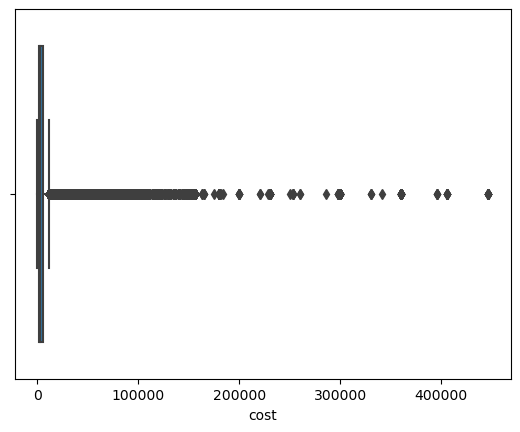

In [26]:
sns.boxplot(data = purchases, x = 'cost')

In [27]:
purchases[purchases['cost'] > 400000].head(100)

,id,product,colour,cost,product_sex,base_sale,dt,name_product,category_product,brand
23511,5319,эхолот lowrance hds12 live с датчиком active i...,нет данных,446420,2.0,0,45,эхолот,отдых/туризм,другое
46020,10318,эхолот lowrance hds12 live с датчиком active i...,нет данных,446420,2.0,0,49,эхолот,отдых/туризм,другое
49245,11072,"велосипед горный merida one forty 700 275""",в нескольких цветах,405999,2.0,0,23,велосипед,спортинвентарь,другое
51589,11613,эхолот lowrance hds12 live с датчиком active i...,нет данных,446420,2.0,0,47,эхолот,отдых/туризм,другое
64475,14520,"велосипед горный merida one forty 700 275""",в нескольких цветах,405999,2.0,0,23,велосипед,спортинвентарь,другое
132510,29699,"велосипед горный merida one forty 700 275""",в нескольких цветах,405999,2.0,0,24,велосипед,спортинвентарь,другое
150396,33820,"велосипед горный merida one forty 700 275""",в нескольких цветах,405999,2.0,0,22,велосипед,спортинвентарь,другое
177834,40024,эхолот lowrance hds12 live с датчиком active i...,нет данных,446420,2.0,0,43,эхолот,отдых/туризм,другое
218745,49636,эхолот lowrance hds12 live с датчиком active i...,нет данных,446420,2.0,0,40,эхолот,отдых/туризм,другое
261268,59553,эхолот lowrance hds12 live с датчиком active i...,нет данных,446420,2.0,0,53,эхолот,отдых/туризм,другое


Есть дорогостоящие товары, но оценивая рынок, такая цена оправдана

### Классификация

In [28]:
personal_data_coeffs.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [29]:
personal_data.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [30]:
dop_data.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


Пропущенных данных нет 

In [31]:
# Заполняем необходимый столбец, используя personal_coef
personal_data = personal_data.merge(personal_data_coeffs[['id','personal_coef']], on = 'id')
df_for_pred = personal_data.drop('id', axis = 1)

In [32]:
X = df_for_pred.drop('gender', axis = 1)
y = df_for_pred['gender']

In [33]:
# Разделяем признаки на категориальные и числовые
cat_col = ['education']
num_col = ['age', 'city', 'country', 'personal_coef']

In [34]:
# Модель логистической регрессии
ohe = OneHotEncoder(handle_unknown='ignore')
sc = StandardScaler()
lr = LogisticRegression()

In [35]:
prp = ColumnTransformer(transformers = [('num', sc, num_col), ('cat', ohe, cat_col)])
pl = Pipeline(steps=[('prp', prp), ('model', lr)])
y_pred = cross_val_predict(pl, X, y, method='predict')

print("Accuracy:", accuracy_score(y, y_pred))
print("F1-score:", f1_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))

Accuracy: 0.977801683082888
F1-score: 0.9809955966576809
Precision: 0.9627544391511477
Recall: 0.9999413283266839


In [36]:
# Модели леса
dt_c = DecisionTreeClassifier(random_state=42)

prp = ColumnTransformer(transformers = [('cat', ohe, cat_col)], remainder="passthrough")
pl1 = Pipeline(steps=[('prp', prp), ('model', dt_c)])

y_pred1 = cross_val_predict(pl1, X, y)

print("Accuracy:", accuracy_score(y, y_pred1))
print("F1-score:", f1_score(y, y_pred1))
print("Precision:", precision_score(y, y_pred1))
print("Recall:", recall_score(y, y_pred1))

Accuracy: 1.0
F1-score: 1.0
Precision: 1.0
Recall: 1.0


In [37]:
rf_c = RandomForestClassifier(random_state=42)
prp = ColumnTransformer(transformers = [('cat', ohe, cat_col)], remainder="passthrough")
pl2 = Pipeline(steps=[('prp', prp), ('model', rf_c)])

y_pred2 = cross_val_predict(pl2, X, y)

print("Accuracy:", accuracy_score(y, y_pred2))
print("F1-score:", f1_score(y, y_pred2))
print("Precision:", precision_score(y, y_pred2))
print("Recall:", recall_score(y, y_pred2))

Accuracy: 0.999910355105837
F1-score: 0.9999217756917962
Precision: 0.9998631154914154
Recall: 0.9999804427755613


In [38]:
# Добавляем пропущенный столбец с полом клиента
dop_data = dop_data.merge(personal_data_coeffs[['id','personal_coef']], on = 'id')

In [39]:
pl1.fit(X, y)

Pipeline(steps=[('prp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['education'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [40]:
X_dop = dop_data[num_col + cat_col]
y_dop_pred = pl1.predict(X_dop)
dop_data['gender'] = y_dop_pred.astype(int)

In [41]:
#### СОХРАНЯЕМ ФАЙЛ
dop_data.to_csv('Предсказание пола покупателей.csv', index=False, encoding='utf-8')

In [42]:
dop_data.shape

(15748, 7)

In [43]:
dop_data.head()

,id,age,education,city,country,personal_coef,gender
0,101492,32,среднее,1188,32,0.4304,1
1,42690,20,высшее,1134,32,0.4688,1
2,113001,27,среднее,1187,32,0.4304,1
3,163654,49,высшее,1160,32,0.5584,0
4,69523,44,среднее,1137,32,0.5072,0


In [44]:
dop_data['gender'].value_counts()

1    8939
0    6809
Name: gender, dtype: int64

In [45]:
# Объединяем данные
df_full = pd.concat([personal_data, dop_data], ignore_index=True)

# Оставляем только страну 32
df_full = df_full[df_full.country == 32]
df_full

,id,gender,age,education,city,country,personal_coef
0,0,0,36,среднее,1201,32,0.5072
1,4,0,35,среднее,1134,32,0.5072
2,6,1,52,среднее,1188,32,0.4304
3,7,0,37,среднее,1198,32,0.5072
4,9,0,48,среднее,1134,32,0.5072
...,...,...,...,...,...,...,...
104984,135183,1,44,среднее,1134,32,0.4304
104985,125993,1,46,среднее,1134,32,0.4304
104986,167019,0,71,среднее,1134,32,0.5072
104987,116355,1,32,среднее,1188,32,0.4304


<AxesSubplot:xlabel='age'>

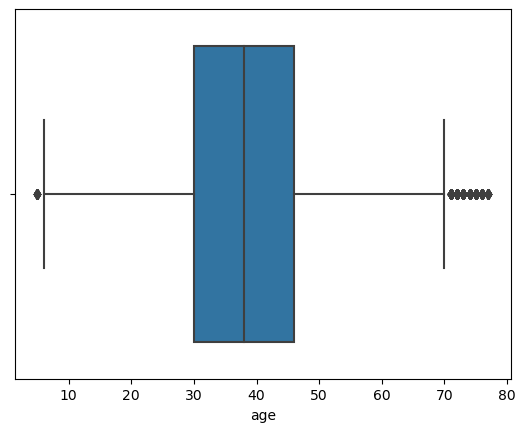

In [46]:
# Смотрим выбросы в age
sns.boxplot(data = df_full, x = 'age')

In [47]:
# Удаляем клиентов, возраст которых младше 14 лет и старше 70
df_clean = df_full[(df_full['age'] >= 14) & (df_full['age'] <= 70)].copy()                      
df_clean.shape

(102992, 7)

In [48]:
# Объединим все один датафрейм
df = purchases.merge(df_clean, on = 'id')
df.shape

(769308, 16)

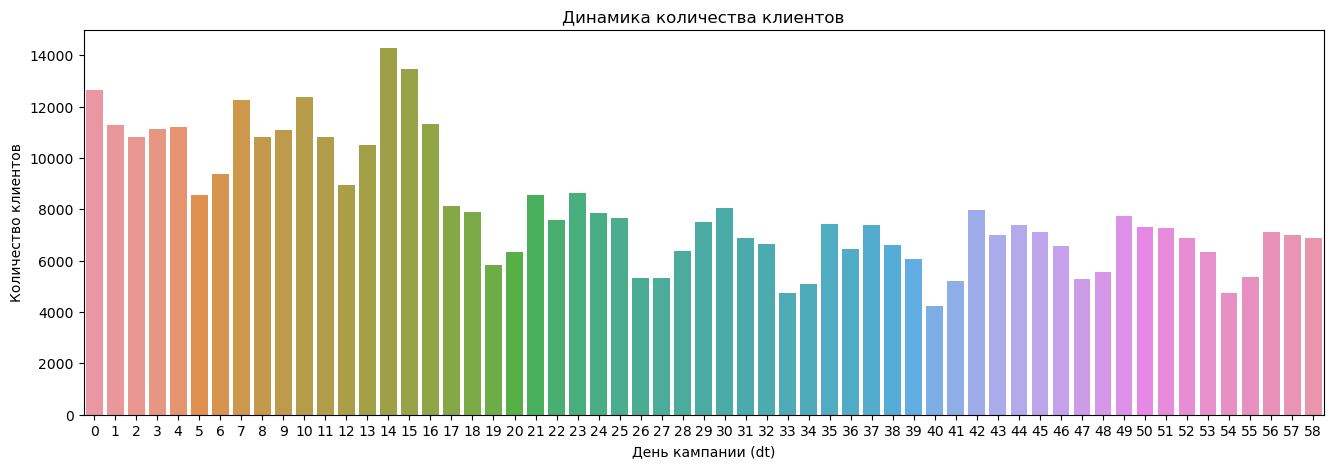

In [49]:
df_day = df.groupby('dt')['id'].nunique().reset_index(name = 'num_buyers')

plt.figure(figsize = (16, 5))
sns.barplot(data = df_day, x = 'dt', y = 'num_buyers')
plt.title('Динамика количества клиентов')
plt.ylabel('Количество клиентов')
plt.xlabel('День кампании (dt)')

plt.show()

In [53]:
# Для тех, кто по возрасту меньше 22 заменим образование на среднее
df.loc[df['age'] < 22, 'education'] = 'среднее'
df['product_sex'] = df['product_sex'].astype(int)

In [54]:
df.to_csv('full_data_new.csv', index=False, encoding='utf-8')